In [38]:
# import libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

# Part I

Logic of the sample system: A record is created in van-order when user places an order. Each order starts at order_subset A, and each order can be accepted by multiple drivers. There will be a new record in the vaninterest table when a driver accepts an order. After accepting order, the driver has the option to reject an order, which will go back to the pool and allow other drivers to match this order again.

a) For hours with orders, how many orders are there each hour based on order time?

b) What is the percentage of money spent for each of the following group of clients?
- Clients who completed 1 order
- Clients who completed more than 1 order

c) List of unique Client ID who completed at least one order, also show each client's total money spent, and the total order(s) completed. Order the list by total money spent (descending), then by total order(s) completed (descending)


d) List of all drivers who took order(s) (regardless of whether they eventually complete the order), also show each driver's total income and total order(s) completed. Order the list by total income (descending), then by total order(s) completed

e) List of driver ID who took orders, but never complete an order?

***

# Part II

We would like to test the impact of a change introduced at ‘2017-03-30 12:00:00 AM’ on our Order Allocation system. The objective of the change is to improve order Match Time, which is the duration since the time an order was created to the time the order was accepted by a driver. 

- What is the resulting impact from this change?
- Any additional insights or observations you think are worth noting?
- Any observations regarding the testing process or environment? How would you improve or redesign this experiment?



## Explore the data

In [2]:
# read csv
df = pd.read_csv('response_data.csv')

In [3]:
df.head()

,Driver Response Timestamp,Order Create Timestamp,Order Id
0,3/24/17 22:58:31,3/24/17 22:57:38,1
1,3/25/17 1:04:53,3/25/17 1:04:53,2
2,3/25/17 1:06:16,3/25/17 1:06:16,3
3,3/25/17 1:08:40,3/25/17 1:07:03,4
4,3/25/17 2:34:18,3/25/17 2:34:08,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Driver Response Timestamp  5000 non-null   object
 1   Order Create Timestamp     5000 non-null   object
 2   Order Id                   5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [5]:
# create column for the time difference between order create and driver response
df['Driver Response Timestamp'] = pd.to_datetime(df['Driver Response Timestamp'])
df['Order Create Timestamp'] = pd.to_datetime(df['Order Create Timestamp'])

df['Order Match Time'] = df['Driver Response Timestamp'] - df['Order Create Timestamp']

In [7]:
# Create a column to Change timedleta to seconds
df['Order Match Seconds Difference'] = df['Order Match Time'].dt.total_seconds()

In [8]:
# Create a column for the Order creation date
df['Order Create Day'] = df['Order Create Timestamp'].dt.date

In [9]:
df.head()

,Driver Response Timestamp,Order Create Timestamp,Order Id,Order Match Time,Order Match Seconds Difference,Order Create Day
0,2017-03-24 22:58:31,2017-03-24 22:57:38,1,0 days 00:00:53,53.0,2017-03-24
1,2017-03-25 01:04:53,2017-03-25 01:04:53,2,0 days 00:00:00,0.0,2017-03-25
2,2017-03-25 01:06:16,2017-03-25 01:06:16,3,0 days 00:00:00,0.0,2017-03-25
3,2017-03-25 01:08:40,2017-03-25 01:07:03,4,0 days 00:01:37,97.0,2017-03-25
4,2017-03-25 02:34:18,2017-03-25 02:34:08,5,0 days 00:00:10,10.0,2017-03-25


In [10]:
# Calculate the average Order matching second each day using group by function
df1 = df.groupby(['Order Create Day'])['Order Match Seconds Difference'].mean()

In [11]:
# Convert series into Dataframe
df1 = pd.DataFrame({'Date':df1.index, 'Average Order Matching Seconds':df1.values})
df1

,Date,Average Order Matching Seconds
0,2017-03-24,53.000000
1,2017-03-25,55.877095
2,2017-03-26,33.602349
3,2017-03-27,50.013605
4,2017-03-28,52.187500
5,2017-03-29,52.904918
6,2017-03-30,53.400631
7,2017-03-31,53.045564
8,2017-04-01,94.528958
9,2017-04-02,34.213462


***

We may look at the data with Statisical test.
####  Assume that the duration after the introduction of change is significantly different from before
- H0 : |After - Before| = 0
- H1 : |After - Before| > 0

In [12]:
# Create two dataset: Before and After 
Before = df1[df1['Date'] < pd.Timestamp('2017-03-30')]
After = df1[df1['Date'] >= pd.Timestamp('2017-03-30')]

In [13]:
Before

,Date,Average Order Matching Seconds
0,2017-03-24,53.000000
1,2017-03-25,55.877095
2,2017-03-26,33.602349
3,2017-03-27,50.013605
4,2017-03-28,52.187500
5,2017-03-29,52.904918


In [14]:
After

,Date,Average Order Matching Seconds
6,2017-03-30,53.400631
7,2017-03-31,53.045564
8,2017-04-01,94.528958
9,2017-04-02,34.213462
10,2017-04-03,38.250000


In [15]:
# Before Stat
Before_stat = Before['Average Order Matching Seconds'].describe()
Before = pd.DataFrame({'Stat':Before_stat.index, 'Before':Before_stat.values})

# After Stat
After_stat = After['Average Order Matching Seconds'].describe()
After = pd.DataFrame({'Stat':After_stat.index, 'After':After_stat.values})

# Join tables and drop rows that are unrelevant
drop_rows = [3,4,5,6,7]
stat = pd.merge(Before,After, on='Stat')
stat.drop(drop_rows, inplace=True)
stat

,Stat,Before,After
0,count,6.000000,5.000000
1,mean,49.597578,54.687723
2,std,8.058231,23.880282


In [31]:
# Calculate z-score
Before_count = stat.iloc[0]['Before'].astype(int)
Before_mean = stat.iloc[1]['Before']
Before_std = stat.iloc[2]['Before']

After_count = stat.iloc[0]['After'].astype(int)
After_mean = stat.iloc[1]['After']
After_std = stat.iloc[2]['After']

z_score = (After_mean - Before_mean)/ math.sqrt((After_std**2)/After_count + (Before_std**2)/Before_count)
z_score

0.45550222436075727

In [32]:
import scipy.stats

# find p-value
scipy.stats.norm.sf(abs(z_score))

0.3243739838392138

### The p-value shows the result is not siginificant
Thereore, the duration after the introduction of change is not significantly different to the duration before the introduction of change

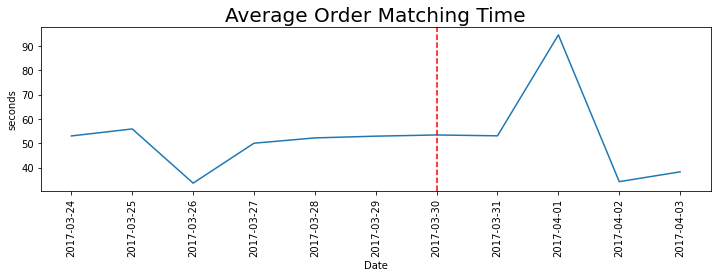

In [41]:
# visualize
plt.figure(figsize=(12,3))
plt.plot(df1['Date'],df1['Average Order Matching Seconds'])

plt.title('Average Order Matching Time', fontsize=20)
plt.xlabel('Date')
plt.ylabel('seconds')
plt.xticks(df1['Date'], rotation=90)
plt.axvline(pd.Timestamp('2017-03-30') , color='r', linestyle='--')

plt.show()

Even though the pvalue shows that the average duration before and after the change was introduced was not significant. However, we can see that the duration increases dramtically on the third day after the change was introduced, and decreases dramtically on the forth day. 

# Conclusion
- Average of the duration since the time an order was created to the time the order was accepted by a driver has increased by 10 seconds
- Variation in the duration has greatly increased after the change was introduced 
- Durations on the forth and fifth day are lower than the average duration before
- More observations days were needed